## *Game Winner* - Machine Learning Models Final Project
## <font size=5 color='gray'>Daniel Behar</font>

*Context of the game:* CS:GO is a tactical classic shooter game. There are plenty of game modes, but for this model I picked only Competitive Mode data. In this mode, there's two teams (CT and Terrorist) with 5 players each team. They play for a best of 30 rounds (16 rounds winner wins the game) and each round is limited to 1 minute and 55 seconds. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. This dataset holds only 8 different maps from the game. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb after it was planted.

The goal of the project is to select and create the best prediction algorithm to predict which of the two teams of the game will win the round, depending on previous results and their decisions preparing for the round. This is the last project of Machine Learning Models course.
#### Structure of the notebook:
* `Libraries`: Includes a briefly description of where they were used in the process
* `Data Export`: Includes the data export, separation in train-test and exploration
* `Cleaning Pipelines`: Building the two pipelines that I used
* `Model`: Building the pipeline where I'm placing my model

## Importing Libraries

In [1]:
#General use libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

#To split into train and test
from sklearn.model_selection import train_test_split

#Full Pipeline
from sklearn.compose import ColumnTransformer

#Normality Test
from scipy.stats import shapiro

#Numeric Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#Categoric Pipeline
from sklearn.preprocessing import OneHotEncoder

#Final model and models tested
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

#Checking for strange values (my func)
def unique(column):
    """ Unique. Receives a column name and
        returns all the unique values in it
        
    Args:
        column (str): The name of the column to analyse

    Returns:
        the counts of the unique values
    """
    return data[column].value_counts()

#Normalicer function
def normalizer(column):

    df_max_scaled = data.copy()
    data[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()
    
    return True

%matplotlib inline

## Data
* Getting the data
* Extracting round_winner from the set
* Creating train and test sets from the dataset

In [2]:
#Data will be the data that I'll use to create and train the model, datat is the data for which I want to predict the isFraud variable
data = pd.read_csv("csgo.csv")

In [3]:
data.head(5)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.0,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,.156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,.96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,.76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,.174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


Distribution of T and CT in the data (distribution of winners)

In [4]:
#The predicted value is balanced
unique("round_winner")

T     62406
CT    60004
Name: round_winner, dtype: int64

In [5]:
#Extracting the predicted value and removing it from the dataset
y = data.loc[:,"round_winner"]
data.drop(["round_winner", "time_left"],axis=1,inplace=True)
print(data.shape)
print(y.shape)

(122410, 95)
(122410,)


Comments:
- There are some guns in the game that were not used, so the model can't know their influence in a match. For that reason I deleted all columns with a grand total of 0
- time_left didn't helped in any model, so I removed it

In [6]:
#Removing the columns that doesn't have any registry

column_sums = data.sum()
columns_to_drop = column_sums.loc[column_sums == 0].index

#Drop the selected columns from the DataFrame
data = data.drop(columns=columns_to_drop)
print(data.shape)

(122410, 89)


### Exploring data
* Search for NA values and not normal observations
* Searching for relevant information about the data

In [7]:
#Unique values in the y variable
np.unique(y)

array(['CT', 'T'], dtype=object)

In [8]:
#% of NAs for each column
nas = pd.DataFrame(data.isna().sum()/data.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,ct_score,0.0
1,t_score,0.0
2,map,0.0
3,bomb_planted,0.0
4,ct_health,0.0
...,...,...
84,t_grenade_incendiarygrenade,0.0
85,ct_grenade_molotovgrenade,0.0
86,t_grenade_molotovgrenade,0.0
87,ct_grenade_decoygrenade,0.0


Because this data was extracted from servers in the game, there are no NAs. All the NULL values were translated to 0

In [9]:
unique("map")


de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: map, dtype: int64

All this maps exist and are very popular in the CSGO community

Data behavior

In [10]:
data.describe()

,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,2.773638,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,2.010915,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,5.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


Comments from this exploration:
- It's not normal to have scores upper than 16 in any team
- Health can't be upper than 500
- In some rounds there are 6 players (that explains the registry of 600 in health), but that shouldn't be allowed, it's, maybe, a bug
- Players can buy as many guns as their available money allows it, so in guns and grenades it's normal to see more than 5 items per team on each category
- Guns and grenades variables have normal values

In [11]:
#Searching for strange values in the scores variables
unique("ct_score")
unique("t_score")

0.0     12161
3.0      9106
5.0      8682
4.0      8638
1.0      8581
6.0      8479
7.0      8008
8.0      7576
2.0      7268
9.0      7255
10.0     6408
11.0     6370
12.0     6090
13.0     5362
14.0     5113
15.0     4743
18.0      686
16.0      452
17.0      450
19.0      241
21.0      200
20.0      150
24.0       85
23.0       68
25.0       38
27.0       37
26.0       35
29.0       34
28.0       28
22.0       22
30.0       16
31.0       11
33.0        9
32.0        8
Name: t_score, dtype: int64

In both scores the % of values upper than 16 is less than 5%, so I´ll replace to 16 in the numbers upper that 16

In [12]:
#Chainging the values
data['ct_score'] = np.where(data['ct_score'] > 16, 16, data['ct_score'])
data['t_score'] = np.where(data['t_score'] > 16, 16, data['t_score'])
data['t_health'] = np.where(data['t_health'] > 500, 500, data['t_health'])
data['t_players_alive'] = np.where(data['t_players_alive'] > 500, 500, data['t_players_alive'])

In [13]:
unique("t_health")
unique("t_players_alive")

5.0    80901
4.0    15958
3.0    10915
2.0     7667
1.0     5802
0.0     1166
6.0        1
Name: t_players_alive, dtype: int64

There's only 1 observation of 6 alive players. That explains why there is 600 health points once. I'll replace the 600 health points in 500 and the 6 players number into 5

I will plot score, health, armor and money, that are the only numeric variables that don't are influenced directly by the players and are the only continous variables, the others are partially discreet

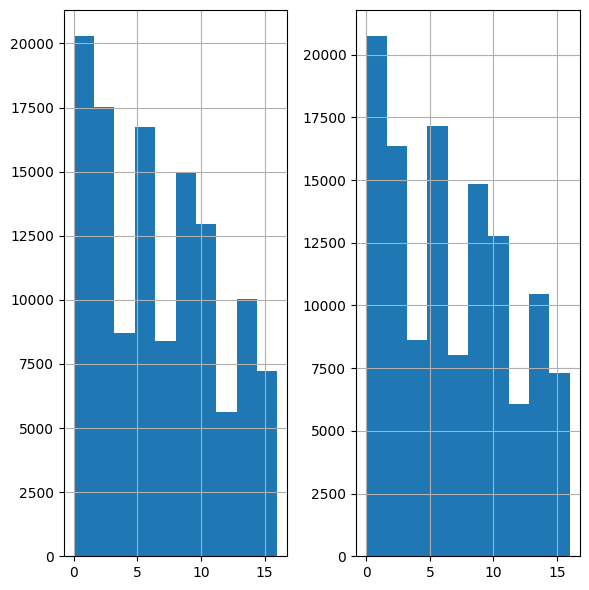

In [14]:
#Plotting the scores of both teams
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)

data["ct_score"].hist(figsize=(6,6), ax=axes[0])
data["t_score"].hist(figsize=(6,6), ax=axes[1])

plt.show()

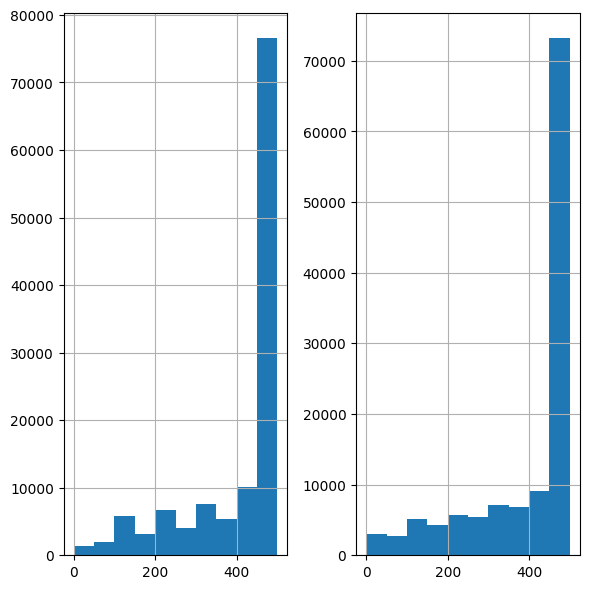

In [15]:
#Plotting the health of both teams
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)

data["ct_health"].hist(figsize=(6,6), ax=axes[0])
data["t_health"].hist(figsize=(6,6), ax=axes[1])

plt.show()

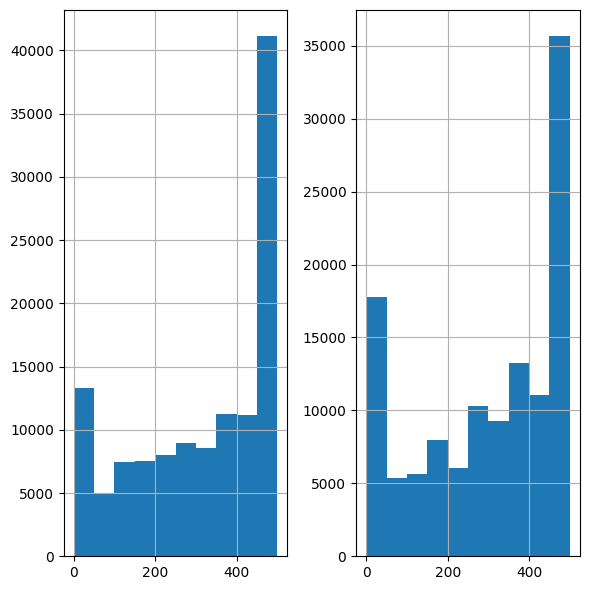

In [16]:
#Plotting the armor of both teams
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)

data["ct_armor"].hist(figsize=(6,6), ax=axes[0])
data["t_armor"].hist(figsize=(6,6), ax=axes[1])

plt.show()

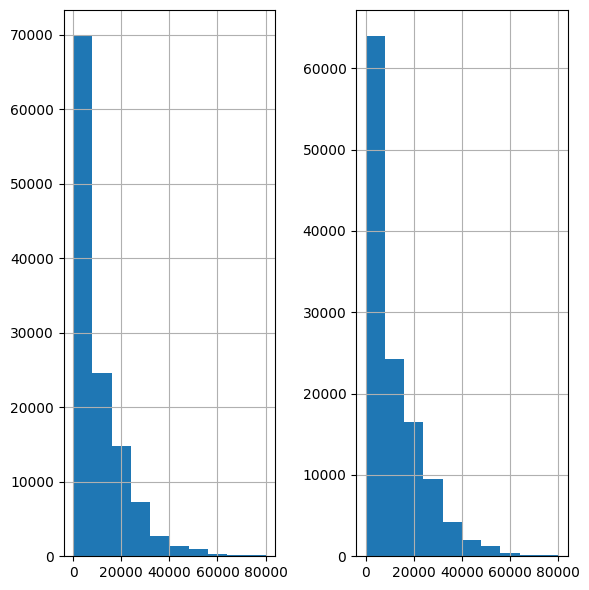

In [17]:
#Plotting the money of both teams
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 2)

data["ct_money"].hist(figsize=(6,6), ax=axes[0])
data["t_money"].hist(figsize=(6,6), ax=axes[1])

plt.show()

All this four variables have almost the same distribution between teams, there is no need to normalice data, at this point. This is a normal behaviour in all variables

### Normality tests

Doing some normality tests in the continous variables

In [18]:
#Normality test scores
stat, p = shapiro(data['t_score'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

#Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('t_score')
    print('ready')

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.949, p=0.00000
ready


In [19]:
#Normality test health
stat, p = shapiro(data['t_health'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

#Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('t_health')
    print('ready')

Statistics=0.730, p=0.00000
ready


In [21]:
#Normality test armor
stat, p = shapiro(data['ct_armor'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

#Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('ct_armor')
    print('ready')

Statistics=0.884, p=0.00000
ready


In [23]:
#Normality test money
stat, p = shapiro(data['ct_money'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

#Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('ct_money')
    print('ready')

Statistics=0.800, p=0.00000
ready


In [24]:
print(data.dtypes)

ct_score                       float64
t_score                        float64
map                             object
bomb_planted                      bool
ct_health                      float64
                                ...   
t_grenade_incendiarygrenade    float64
ct_grenade_molotovgrenade      float64
t_grenade_molotovgrenade       float64
ct_grenade_decoygrenade        float64
t_grenade_decoygrenade         float64
Length: 89, dtype: object


In [25]:
#Creating train and test subsets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=20)

After reviewing the data, there is no need to treat the numeric data because it is standarized data, where nas are changed to 0 before we receive it

## Pipelines to clean the data

### Categoric Pipeline

In [26]:
categoric_pipeline = Pipeline([
                        ('Imputador', SimpleImputer(strategy="most_frequent")),
                        ('ohe', OneHotEncoder())
                        ])

Testing the pipeline. Categoricas contains the raw columns, categorical contains the processed data

In [27]:
categorical = categoric_pipeline.fit_transform(data.select_dtypes(exclude='number'))
categorical.toarray()[0,:]

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])

### Full pipeline

In [28]:
categorical_attributes = data.select_dtypes(exclude='number').columns 

full_cleaning_pipeline = ColumnTransformer([
        ("categorics", categoric_pipeline, categorical_attributes)
    ])

In [29]:
full_cleaning_pipeline.fit(data)
ready_Xtrain = full_cleaning_pipeline.transform(X_train)
ready_Xtest = full_cleaning_pipeline.transform(X_test)

print(ready_Xtrain.shape)
print(ready_Xtest.shape)

(85687, 10)
(36723, 10)


## Model

### Models selection
My first approach will be using random forest to try to predict the winner

In [30]:
randomF_test = Pipeline([
        ("data_preparation", full_cleaning_pipeline),
        ("DTC", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16
                                       , random_state=42, n_jobs=-1))
    ])

randomF_test.fit(X_train, y_train)
predicted_vals = randomF_test.predict(X_test)

print('DecisionTreeClassifier:\n')
print('F1: {0}'.format(f1_score(y_test,predicted_vals,average='weighted')))
print('Precision Score: {0}'.format(precision_score(y_test,predicted_vals,average='weighted')))
print('Recall Score: {0}'.format(recall_score(y_test,predicted_vals, average='weighted')))
cm = confusion_matrix(y_test,predicted_vals)

DecisionTreeClassifier:

F1: 0.557441058859389
Precision Score: 0.5574367299483081
Recall Score: 0.5576069493233123


###  Final Model

In [81]:
predictor_pipeline = Pipeline([
        ("data_preparation", full_cleaning_pipeline),
        ("DTC", DecisionTreeClassifier(random_state=10000))
    ])

predictor_pipeline.fit(X_train, y_train)
predicted_vals = predictor_pipeline.predict(X_test)

print('DecisionTreeClassifier:\n')
print('F1: {0}'.format(f1_score(y_test,predicted_vals,average='weighted')))
print('Precision Score: {0}'.format(precision_score(y_test,predicted_vals,average='weighted')))
print('Recall Score: {0}'.format(recall_score(y_test,predicted_vals, average='weighted')))
cm = confusion_matrix(y_test,predicted_vals)

DecisionTreeClassifier:

F1: 0.557441058859389
Precision Score: 0.5574367299483081
Recall Score: 0.5576069493233123


<AxesSubplot: >

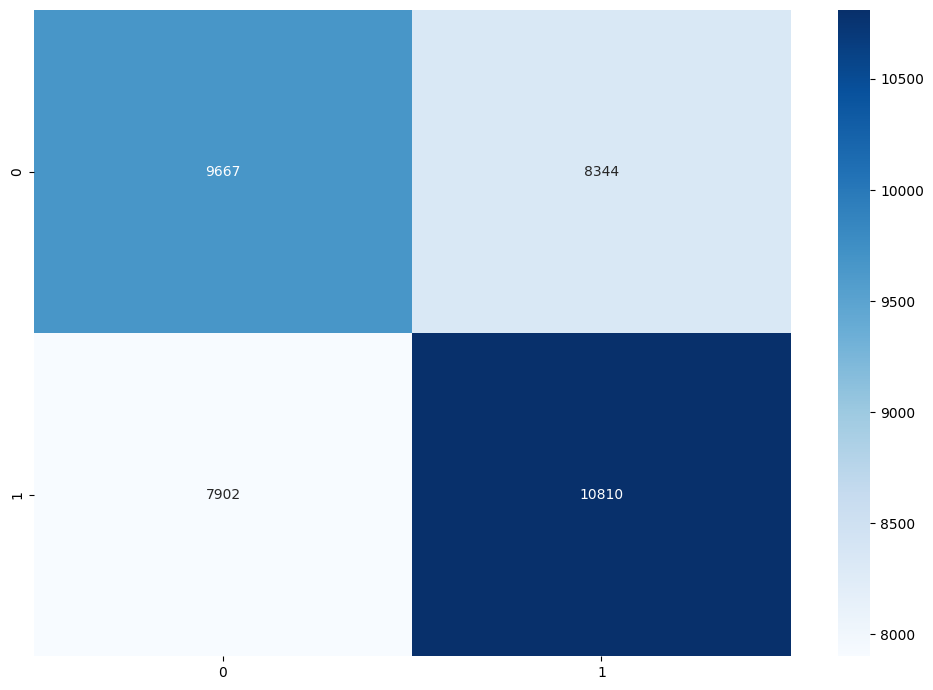

In [82]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')